In [1]:
import sys
from anomaly_detection_models import SALAD, DataVsSim, CWoLa, SACWoLa

sys.path.append('../../ATLAS_anomaly_detection/.')
sys.path.append('../../ATLAS_anomaly_detection/decorrelation/.')
from utils import load_LHCO
from helpers import add_vars

import matplotlib.pyplot as plt
import numpy as np
import pandas as pdb
import keras

ModuleNotFoundError: No module named 'anomaly_detection_models'

## load test dataset

here we use LHCO dataset, and cheat by calling some locally defined commands to load it. 

In [35]:
lhco = load_LHCO()
data, sim, signal = add_vars(lhco['pythia_qcd']), add_vars(lhco['herwig_qcd']), add_vars(lhco['wprime'])

## load data

the best way to do this is to specify a training and testing version of the features, signal tags, simulation vs data tags, and sb tags.

In [3]:
from sklearn.model_selection import train_test_split

n_signal = 1500
cols = ['mJJ', 'maxmass', 'minmass', 'tau21a', 'tau21b']

test_frac = 0.5

x_data,x_data_test,x_sim,x_sim_test = train_test_split(data.loc[:,cols].values, sim.loc[:,cols].values, test_size=test_frac) 

signal_idx = np.random.choice(len(signal), n_signal, replace=False)

x = np.concatenate([x_data, x_sim, signal.loc[:,cols].iloc[signal_idx].values])
x[:,:3]/=1000
y_signal = np.concatenate([np.zeros(len(x_data)), np.zeros(len(x_sim)), np.ones(len(signal_idx))])
y_sim = np.concatenate([np.ones(len(x_data)), np.zeros(len(x_sim)), np.ones(len(signal_idx))])
y_sr = ((x[:,0] <= 3.7) & (x[:,0] >= 3.3))
y_sb = ((x[:,0] > 3.0) & (x[:,0] < 3.3)) | ((x[:,0] > 3.7) & (x[:,0] < 4.0))

x_test = np.concatenate([x_data_test, x_sim_test, np.delete(signal.loc[:,cols].values, signal_idx, axis=0)])
x_test[:,:3]/=1000
y_sr_test = ((x_test[:,0] <= 3.7) & (x_test[:,0] >= 3.3))
y_sb_test = ((x_test[:,0] > 3.0) & (x_test[:,0] < 3.3)) | ((x_test[:,0] > 3.7) & (x_test[:,0] < 4.0))
y_signal_test = np.concatenate([np.zeros(len(x_data_test)), np.zeros(len(x_sim_test)), np.ones(len(signal) - len(signal_idx))])
y_sim_test = np.concatenate([np.ones(len(x_data_test)), np.zeros(len(x_sim_test)), np.ones(len(signal) - len(signal_idx))])

print(((y_signal==1)&(y_sim==1)&(y_sr==1)).sum()/np.sqrt(((y_signal==0)&(y_sim==1)&(y_sr==1)).sum()))

4.6657463480715995


### create architectures

you can also pass finished models

In [4]:
sb_model = keras.models.Sequential()
sb_model.add(keras.layers.Dense(64, input_shape=(5,), activation='relu'))
sb_model.add(keras.layers.Dense(64, activation='relu'))
sb_model.add(keras.layers.Dense(64, activation='relu'))
sb_model.add(keras.layers.Dense(1, activation='sigmoid'))

base_model = keras.models.Sequential()
base_model.add(keras.layers.Dense(64, input_shape=(4,), activation='relu'))
base_model.add(keras.layers.Dense(64, activation='relu'))
base_model.add(keras.layers.Dense(64, activation='relu'))
base_model.add(keras.layers.Dense(1, activation='sigmoid'))

# set architectures
dctr_model_arch = sb_model.to_json()
base_model_arch = base_model.to_json()

In [6]:
# from importlib import reload
# import models
# reload(models)
# from models import *
%run models.py

global_params = {
    'epochs': 1,
    'verbose': 0,
    'model': base_model_arch,
    'batch_size': 200,
    'compile': True
}
clear_session()
models = {    
    'salad': SALAD(**global_params, sb_model=dctr_model_arch, sb_epochs=10, sb_batch_size=200,),
    'dvsim': DataVsSim(**global_params),
    'cwola': CWoLa(**global_params),
    'SACWoLa': SACWoLa(**global_params, lambda_=1.0)
}

for name,m in models.items():
    m.fit(x[:,1:][y_sr | y_sb], y_sim=y_sim[y_sr | y_sb], y_sr=y_sr[y_sr | y_sb], m=x[:,0:1][y_sr | y_sb]).save('data/test/{}'.format(name))

2021-03-18 15:19:05,494 This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f3350eb12b0>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
2021-03-18 15:19:05,601 This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f3351e28be0>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
2021-03-18 15:19:09,952 This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f3345ea1e48>) but is being saved in TensorFlow format with `save_weights`. The mod

In [30]:
%run models.py
# from keras.backend import clear_session
clear_session()
v = SALAD().load('data/test/salad')

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


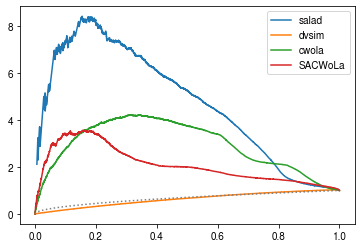

In [146]:
from sklearn.metrics import roc_curve

for name,m in models.items():
    yhat = m.predict(x_test[y_sr_test,1:])
    fpr,tpr,thresh = roc_curve(y_signal_test[y_sr_test], yhat)
    plt.plot(tpr, tpr/np.sqrt(fpr), label=name)
plt.plot(tpr, tpr/np.sqrt(tpr), ls=':', color='tab:grey')
plt.legend()
plt.show()

In [155]:
import keras.backend as K
K.clear_session()

In [ ]:
%run 

In [176]:
model.model.get_weights()

[array([[-5.50626628e-02,  1.24043331e-01, -1.19458131e-01,
         -3.04486364e-01,  1.88472614e-01, -3.14124972e-02,
         -2.11847544e-01,  3.00890882e-03,  8.11250135e-02,
         -2.44014889e-01,  3.77975293e-02,  1.67294234e-01,
         -1.22115277e-02,  5.83098158e-02, -4.96939532e-02,
         -3.32721204e-01, -7.30360970e-02,  2.41796076e-01,
          2.58592278e-01, -3.24605227e-01, -2.17538416e-01,
          8.15834180e-02, -1.61489651e-01, -4.51897644e-02,
          1.44553289e-01,  1.58232301e-01, -2.94155270e-01,
         -6.12946860e-02, -3.96453977e-01, -3.60030025e-01,
         -1.61064446e-01,  2.89974988e-01, -3.47904623e-01,
          2.61122316e-01,  2.35946462e-01, -3.91465686e-02,
          7.60531798e-02, -2.41772935e-01, -3.12918186e-01,
          2.95133054e-01, -2.74206102e-01, -7.18597844e-02,
         -2.06045613e-01,  1.37411311e-01, -3.58493924e-02,
          1.32635444e-01,  6.29336312e-02,  2.40862183e-02,
         -7.10456725e-03,  1.70109749e-0

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff7e8d81908>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 94549489837376
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff7d8656e10>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, st

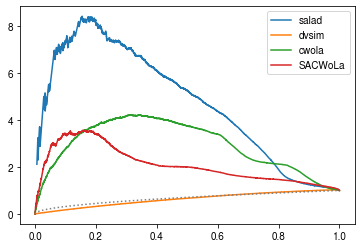

In [166]:
for name,m in models.items():
    copy = m.copy(False).load('data/test/{}'.format(name))
    yhat = copy.predict(x_test[y_sr_test,1:])

    fpr,tpr,thresh = roc_curve(y_signal_test[y_sr_test], yhat)
    plt.plot(tpr, tpr/np.sqrt(fpr), label=name)
plt.plot(tpr, tpr/np.sqrt(tpr), ls=':', color='tab:grey')
plt.legend()
plt.show()

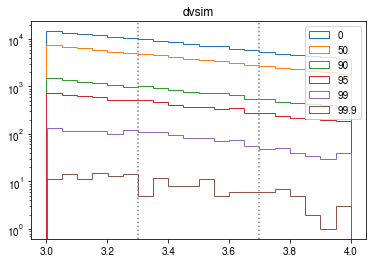

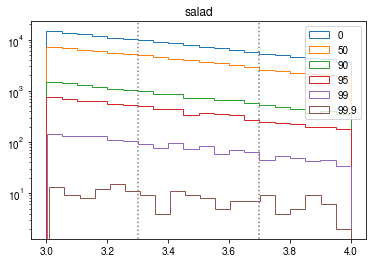

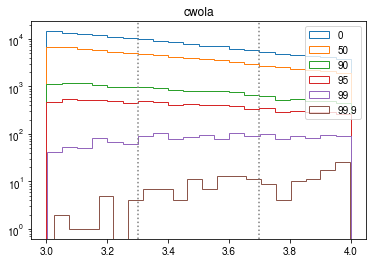

In [809]:

pvals = [0, 50, 90, 95, 99, 99.9]
window = y_sr | y_sb
dtag = y_sim[window] == 1
stag = y_sim[window] == 0

for model_name,m in models.items():
    yhat_all = m.predict(x[window,1:])

    for p in pvals:
        pct = np.percentile(yhat_all[dtag], p)
        tag = yhat_all[dtag] >= pct

        plt.hist(x[window,0][dtag][tag], histtype='step', label=p, density=0, bins=20)

    plt.gca().axvline(3.3, color='tab:grey', ls=':')
    plt.gca().axvline(3.7, color='tab:grey', ls=':')

    plt.title('{}'.format(model_name))
    plt.legend()
    plt.yscale('log')
    plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in subtract


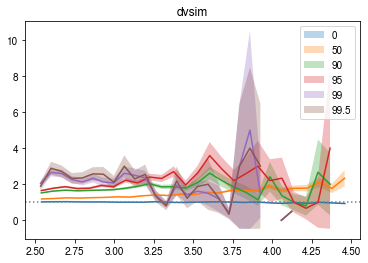

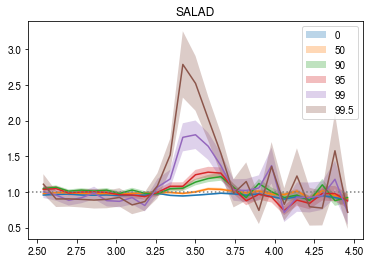

In [677]:
pvals = [0, 50, 90, 95, 99, 99.5]

for model_name,m in {'dvsim': dvsim, 'SALAD': s}.items():
    yhat_all = m.predict(x_test[window])
    if hasattr(m, 'predict_weight'):
        w = m.predict_weight(x_test[window])
    else:
        w = np.ones_like(y_test[window])
        
    for p in pvals:
        pct = np.percentile(yhat_all[dtag], p)
        tag = yhat_all[dtag] >= pct
        tag_s = yhat_all[stag] >= pct

        dcnts,bns = np.histogram(x_test[window,0][dtag][tag], bins=25,)
        scnts,bns = np.histogram(x_test[window,0][stag][tag_s], weights=w[stag][tag_s], bins=25,)
        xpt = bns[:-1] + np.diff(bns)*.5

        val = (dcnts/scnts)
        err = val*np.sqrt(1/dcnts + 1/scnts)

        plt.plot(xpt, val)
        plt.fill_between(xpt, val - err, val + err, alpha=.3, label=p)

    plt.legend()
    plt.axhline(1, color='tab:grey', ls=':')
    plt.title(model_name)
    plt.show()

In [ ]:
w_sb = s.predict_weight(x_tr[sb])
plot_set(x_tr[sb], y_tr[sb], w_sb)

In [ ]:
w_sr = s.predict_weight(x_tr[sr])
plot_set(x_tr[sr], y_tr[sr], w_sr)

In [685]:
%run models.py